In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path_to_scheme = '../data/pur_scheme.csv'

In [79]:
def PET(data, path_to_scheme):
    # Reference: http://www.fao.org/docrep/x0490e/x0490e07.htm
    # use with caution for latitudes out of range 0-67 degrees
    
    # Part 1. Avarage latitude calculation
    # read watershed scheme
    schema = pd.read_csv(path_to_scheme, usecols=[0, 1])
    # calculate mean watershed latitude 
    # and convert it from degrees to radians
    lat = np.deg2rad(schema.Y.values.mean())
    
    # Part 2. Extraterrrestrial radiation calculation
    # set solar constant (in W m-2)
    Rsc = 1367 
    # calculate day of the year array
    doy = np.array([i for i in range(1, 367)])
    # calculate solar declination dt (in radians)
    dt = 0.409 * np.sin(2 * np.pi / 365 * doy - 1.39)
    # calculate sunset hour angle (in radians)
    ws = np.arccos(-np.tan(lat) * np.tan(dt))
    # Calculate sunshine duration N (in hours)
    N = 24 / np.pi * ws
    # Calculate day angle j (in radians)
    j = 2 * np.pi / 365.25 * doy
    # Calculate relative distance to sun
    dr = 1.0 + 0.03344 * np.cos(j - 0.048869)
    # Calculate extraterrestrial radiation (J m-2 day-1)
    Re = Rsc * 86400 / np.pi * dr * (ws * np.sin(lat) * np.sin(dt)\
           + np.sin(ws) * np.cos(lat) * np.cos(dt))
    # convert from J m-2 day-1 to MJ m-2 day-1
    Re = Re/10**6
    
    # Part 3. Avearge daily temperatures calculation derived from long-term observations
    Ta = np.array([data.ix[data.index.dayofyear == x, 'Temp'].mean() for x in range(1, 367)])
    
    # Part 4. PET main equation by (Oudin et al., 2005)
    # lambda (latent heat flux const) = 2.45 MJ kg-1
    # ro (density of water const) = 1000 kg m-3
    # PE im m day -1 should be converted to mm/day (* 10**3)
    # PE = ( Re / (2.45*1000) ) * ( (Ta+5) /100 ) * 10**3     
    # threshhold condition
    # if Ta+5>0 - use Oudin formula, else set to zero
    PE = np.where(Ta+5 > 0, ( Re / (2.45*1000) ) * ( (Ta+5) /100 )*10**3, 0)
    
    return PE

In [80]:
data = pd.read_csv('../data/hbv_s_data.csv', index_col=0, parse_dates=True)

In [81]:
a = PET(data, '../data/pur_scheme.csv')

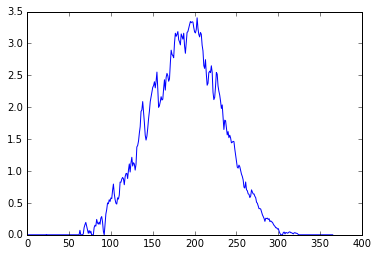

In [82]:
plt.plot(range(len(a)), a)